## 2D Heat Equation using Physics-Informed Neural Networks (PINNs)

This notebook implements a Physics-Informed Neural Network (PINN) in TensorFlow to solve the **2D heat equation**:

$$
u_t = \alpha \left(u_{xx} + u_{yy}\right),
$$

where \(u(x, y, t)\) represents temperature distribution over a square domain \([0, 1] $\times$ [0, 1]\), and $\alpha$ is the thermal diffusivity constant.  

The network is trained to:
- Satisfy the PDE residual (heat conduction dynamics),
- Match initial conditions u(x, y, 0) = $\sin(\pi x)\sin(\pi y)$,
- Enforce zero Dirichlet boundary conditions \(u = 0\) on all spatial boundaries.  

The trained PINN predicts the temperature field across space and time, and results are compared with the exact analytical solution.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
x_i = tf.constant(np.linspace(0,1,500).reshape(500,1), dtype=tf.float32)
y_i = tf.constant(np.linspace(0,1,500).reshape(500,1), dtype=tf.float32)
t_i = tf.zeros_like(x_i)
xyt_i = tf.concat([x_i,y_i,t_i],axis=1)
u_i = tf.sin(np.pi*x_i)*tf.sin(np.pi*y_i)

x_b0 = tf.random.uniform((100,1),minval=0.0,maxval=1.0,dtype=tf.float32)
y_b0 = tf.random.uniform((100,1),minval=0.0,maxval=1.0,dtype=tf.float32)
x_b1 = tf.random.uniform((100,1),minval=0.0,maxval=1.0,dtype=tf.float32)
y_b1 = tf.random.uniform((100,1),minval=0.0,maxval=1.0,dtype=tf.float32)
t_b = tf.random.uniform((100,1),minval=0.0,maxval=1.0,dtype=tf.float32)
xy0t_b = tf.concat([x_b0,tf.zeros((100,1),dtype=tf.float32),t_b],axis=1)
xy1t_b = tf.concat([x_b1,tf.ones((100,1),dtype=tf.float32),t_b],axis=1)
x0yt_b = tf.concat([tf.zeros((100,1),dtype=tf.float32),y_b0,t_b],axis=1)
x1yt_b = tf.concat([tf.ones((100,1),dtype=tf.float32),y_b1,t_b],axis=1)
xyt_b = tf.concat([xy0t_b,xy1t_b,x0yt_b,x1yt_b],axis=0)

x_p = tf.random.uniform((500,1),minval=0.0,maxval=1.0,dtype=tf.float32)
y_p = tf.random.uniform((500,1),minval=0.0,maxval=1.0,dtype=tf.float32)
t_p = tf.random.uniform((500,1),minval=0.0,maxval=1.0,dtype=tf.float32)

t_fixed = 0.5
x_lin = np.linspace(0, 1, 100)
y_lin = np.linspace(0, 1, 100)
x_test, y_test = np.meshgrid(x_lin, y_lin)

xyt_plot = np.hstack([
    x_test.reshape(-1, 1),
    y_test.reshape(-1, 1),
    t_fixed * np.ones((100*100, 1))
])

In [3]:
alpha = 0.3

def exact_solution(x,y,t):
    return np.exp(-2*np.pi*alpha*t)*tf.sin(np.pi*x)*tf.sin(np.pi*y)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(1)
])

Epoch 0, Loss: 0.3400411605834961


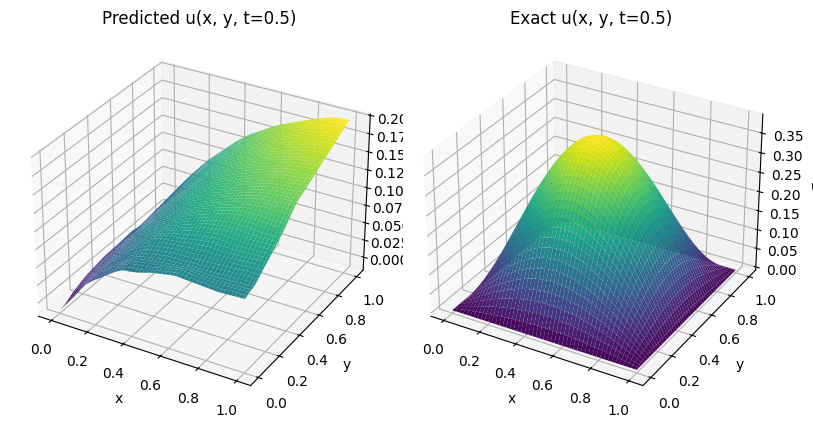

Epoch 1000, Loss: 0.0008362816297449172


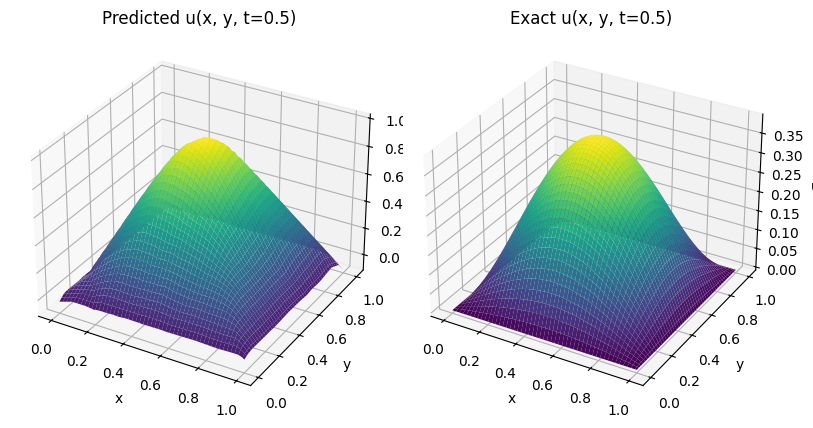

Epoch 2000, Loss: 0.0009194567683152854


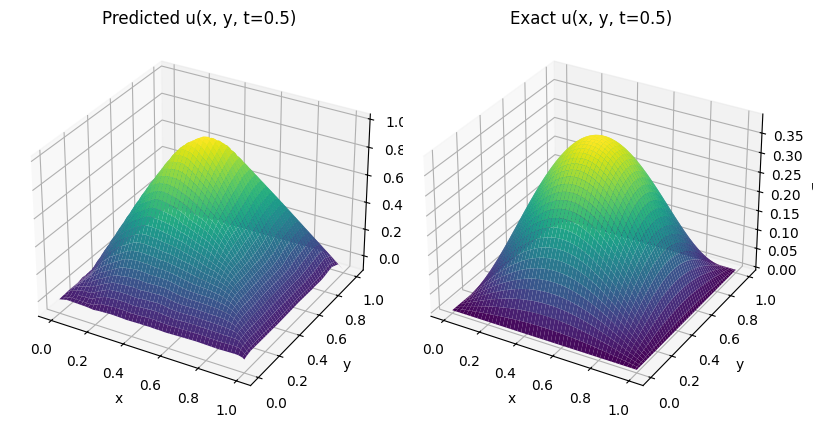

Epoch 3000, Loss: 0.0007333063404075801


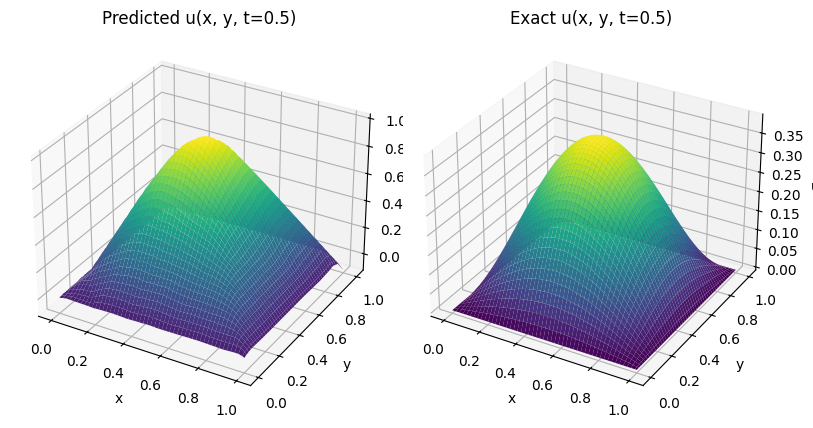

Epoch 4000, Loss: 0.00017393931921105832


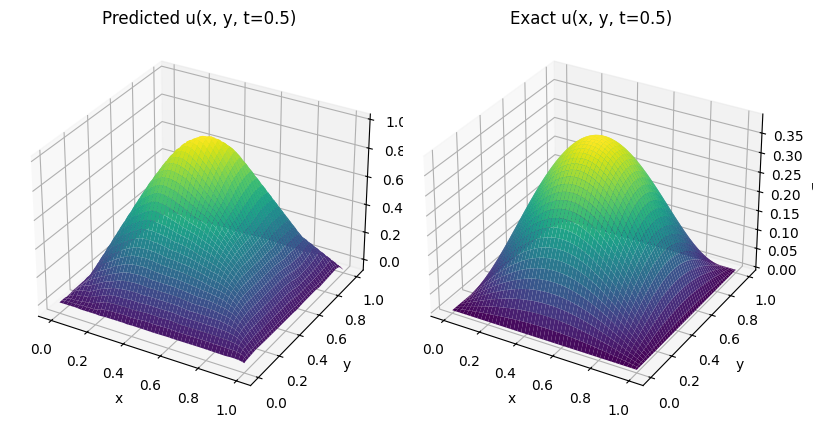

Epoch 5000, Loss: 0.00018654986342880875


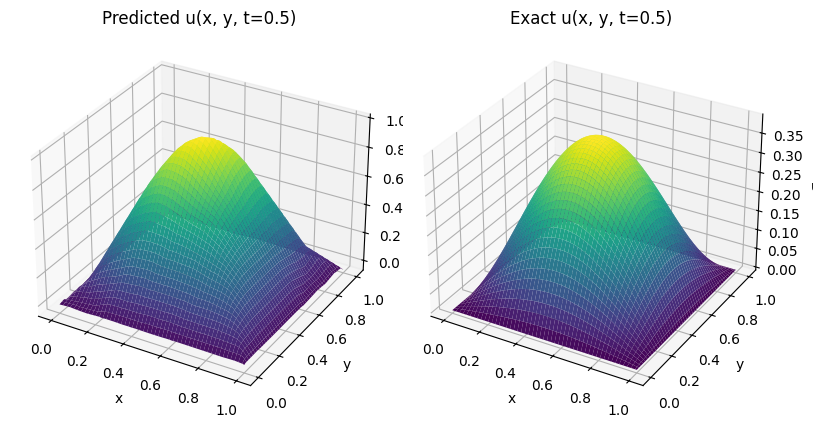

Epoch 6000, Loss: 4.850404729950242e-05


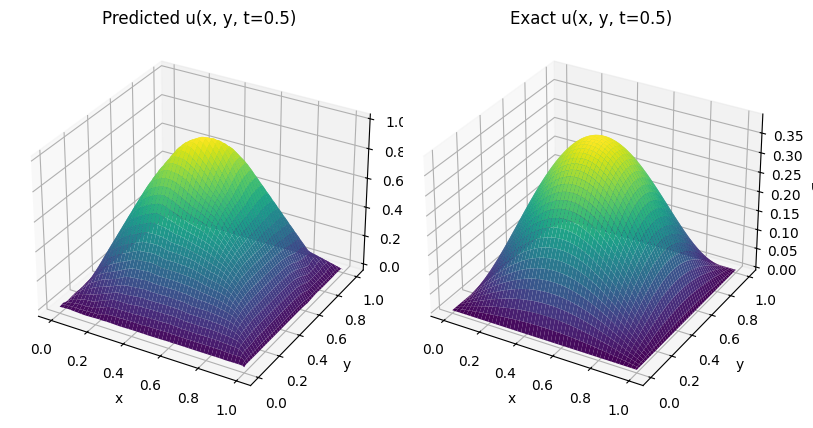

Epoch 7000, Loss: 2.7285641408525407e-05


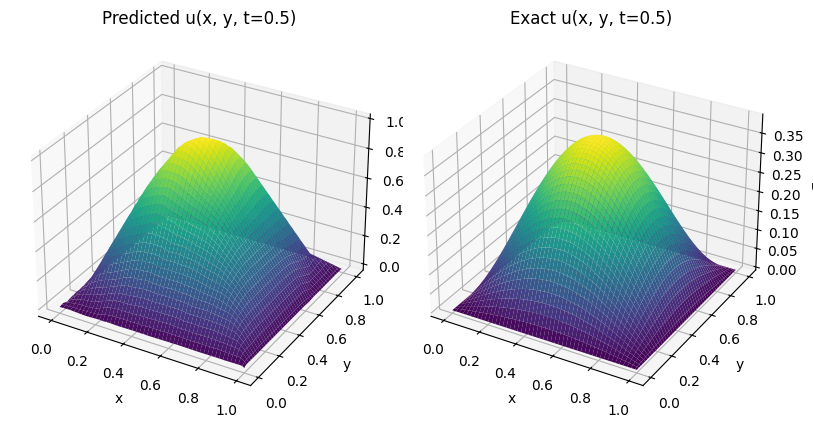

Epoch 8000, Loss: 2.75604470516555e-05


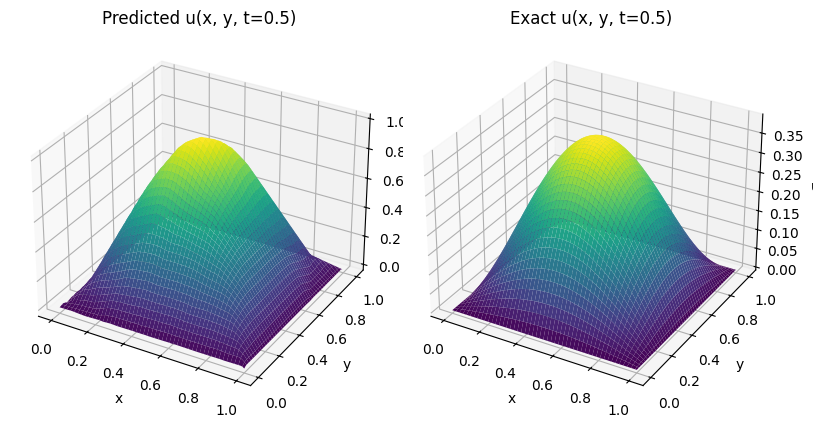

Epoch 9000, Loss: 2.5407998691662215e-05


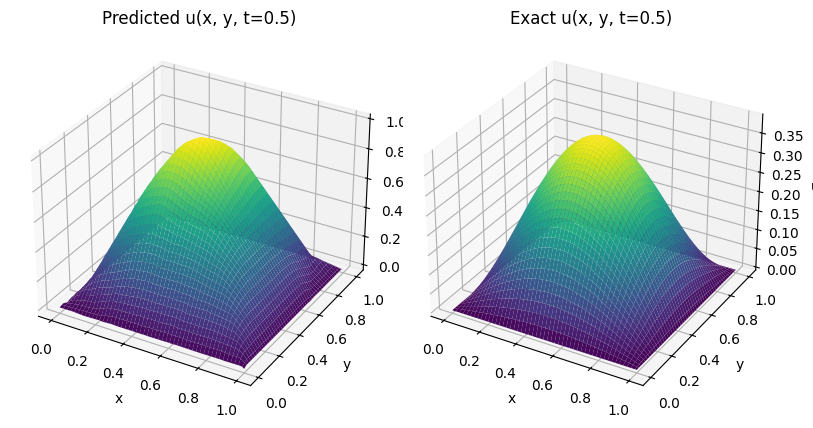

Epoch 10000, Loss: 2.32220882026013e-05


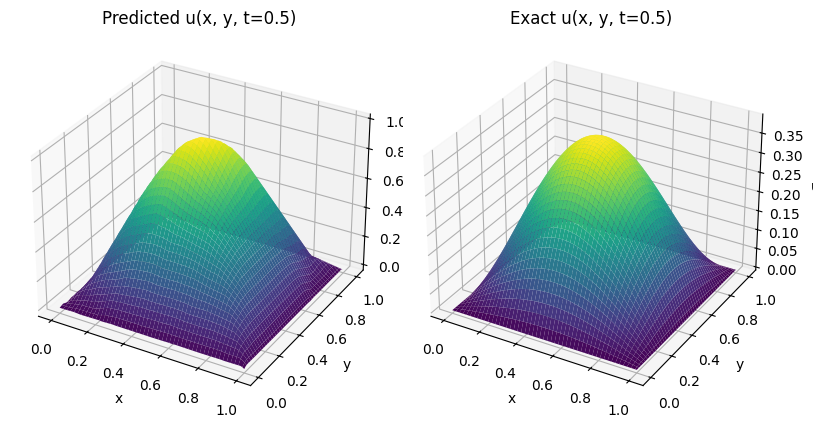

Epoch 11000, Loss: 2.2605283447774127e-05


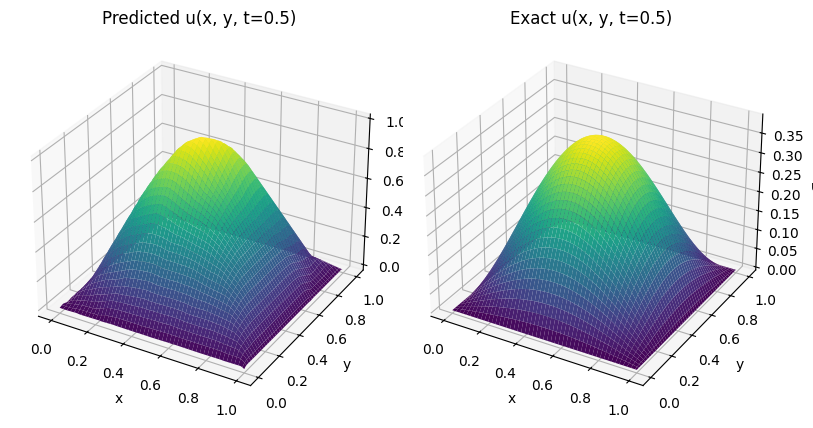

KeyboardInterrupt: 

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 20001

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    up_i = model(xyt_i)
    up_b = model(xyt_b)

    loss_b = tf.reduce_mean(tf.square(up_b))
    loss_i = tf.reduce_mean(tf.square(up_i - u_i))

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_p,y_p,t_p])
      xyt_p = tf.concat([x_p,y_p,t_p],axis=1)
      up_p = model(xyt_p)

      du = tape2.gradient(up_p,xyt_p)
      u_x = du[:,0:1]
      u_y = du[:,1:2]
      u_t = du[:,2:3]
      u_xx = tape2.gradient(u_x,x_p)
      u_yy = tape2.gradient(u_y,y_p)

    loss_p = tf.reduce_mean(tf.square(u_t - alpha*(u_xx + u_yy)))

    loss = loss_b + loss_i + loss_p

  gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))

  if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")


    u_pred = model(tf.constant(xyt_plot, dtype=tf.float32)).numpy().reshape(100, 100)
    u_exact = exact_solution(x_test, y_test, t_fixed)

    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(1,2,1, projection='3d')
    ax.plot_surface(x_test, y_test, u_pred, cmap='viridis')
    ax.set_title(f"Predicted u(x, y, t={t_fixed})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u")

    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.plot_surface(x_test, y_test, u_exact, cmap='viridis')
    ax.set_title(f"Exact u(x, y, t={t_fixed})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u")

    plt.tight_layout()
    plt.show()